# VelocityHack
Swung London Hackathon
1st-2nd June 2019

In [1]:
import lasio
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### Load LAS Data

In [2]:
gn3 = lasio.read('data/GN3.las')

Header section Parameter regexp=~P was not found.


In [3]:
gn3.header

{'Version': [HeaderItem(mnemonic=VERS, unit=, value=2.0, descr=CWLS LOG ASCII STANDARD -V...),
  HeaderItem(mnemonic=WRAP, unit=, value=NO, descr=ONE LINE PER DEPTH STEP)],
 'Well': [HeaderItem(mnemonic=STRT, unit=m, value=8.9916, descr=START DEPTH),
  HeaderItem(mnemonic=STEP, unit=m, value=0.1524, descr=STEP DEPTH),
  HeaderItem(mnemonic=STOP, unit=m, value=2706.1668, descr=STOP DEPTH),
  HeaderItem(mnemonic=NULL, unit=, value=-999.25, descr=NULL VALUE),
  HeaderItem(mnemonic=COMP, unit=, value=, descr=COMPANY),
  HeaderItem(mnemonic=WELL, unit=, value=, descr=WELL),
  HeaderItem(mnemonic=LOC, unit=, value=, descr=LOCATION - AREA),
  HeaderItem(mnemonic=FLD, unit=, value=, descr=FIELD),
  HeaderItem(mnemonic=CTRY, unit=, value=, descr=COUNTRY),
  HeaderItem(mnemonic=DATE, unit=, value=, descr=WELL DATE),
  HeaderItem(mnemonic=XWELL, unit=m, value=, descr=X POS),
  HeaderItem(mnemonic=YWELL, unit=m, value=, descr=Y POS),
  HeaderItem(mnemonic=EDF, unit=, value=6.1, descr=DERRICK FLOOR

In [4]:
gn3['VP']

array([nan, nan, nan, ..., nan, nan, nan])

#### Plot Velocity Log

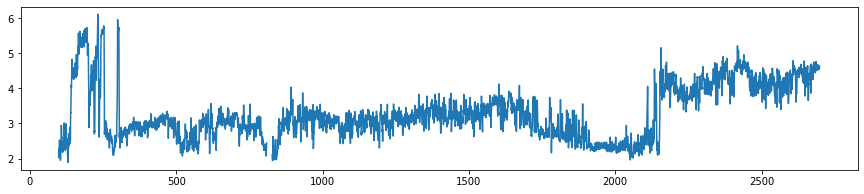

In [5]:
plt.figure(figsize=(15, 3))
plt.plot(gn3['DEPT'], gn3['VP'])
plt.show()

#### Load curves as Pandas dataframe

In [6]:
gn3.df().head()

,DTCO,VP,DTSM,VS,RHOB,CGR,VWCL,PHIT
DEPT,,,,,,,,
8.9916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.1440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.2964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.4488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.6012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


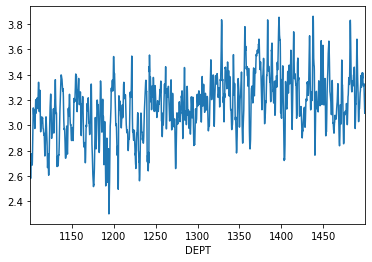

In [7]:
gn3.df().loc[1100:1500].VP.plot()

In [180]:
depth = gn3.df().loc[1100:1500].index.values.reshape(-1,1)
vp =  gn3.df().loc[1100:1500].VP.values.reshape(-1,1)
vp = vp*1000

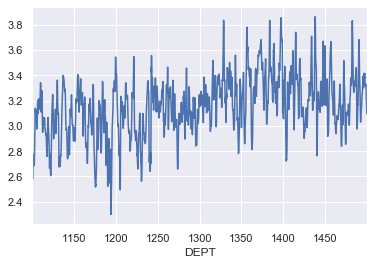

In [183]:
gn3.df().loc[1100:1500].VP.plot()

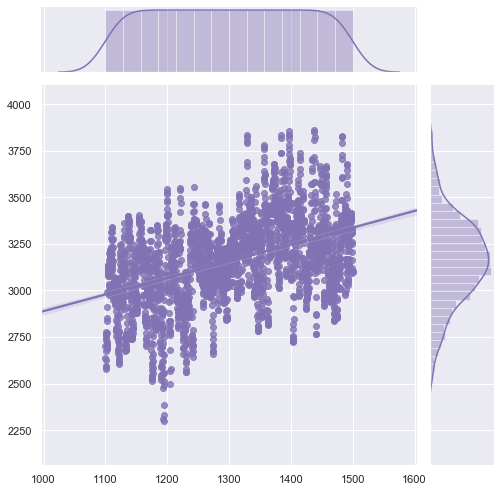

In [184]:
import seaborn as sns
sns.set(style="darkgrid")

g = sns.jointplot(depth, vp, kind="reg", color="m", height=7)

# Simulating pairs of K and V0 

In [185]:
import numpy as np

In [286]:
k = np.random.uniform(-3,3, 10000)
v0 = np.random.uniform(1500,5000, 10000)

In [287]:
k.shape, v0.shape, depth.shape

((10000,), (10000,), (2625, 1))

In [288]:
r = depth*k+v0

In [289]:
r.shape

(2625, 10000)

In [290]:
mse = np.mean((vp-r)**2,axis=0)

In [291]:
rmse = np.sqrt(mse)

In [292]:
import matplotlib.pyplot as plt
%matplotlib inline

In [293]:
rmse = rmse.reshape(-1, 1)
rmse.shape

(10000, 1)

In [294]:
(rmse.max() - rmse.min()) / 10

546.3556531996143

In [295]:
levels = np.linspace(rmse.min(), rmse.max(), 10)

In [296]:
param = np.array([k, v0]).T
param.shape

(10000, 2)

In [297]:
#plt.contourf(param, rmse, [levels] )

In [298]:
k = k.reshape(-1, 1)
v0 = v0.reshape(-1,1)

In [299]:
k.shape, v0.shape, rmse.shape

((10000, 1), (10000, 1), (10000, 1))

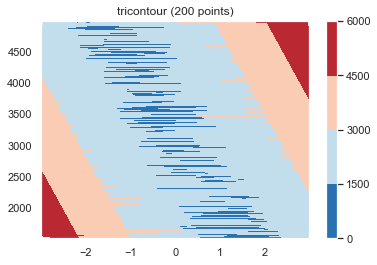

In [300]:
fig, ax2 = plt.subplots(1,1)

#ax2.tricontour(k.flatten(), v0.flatten(), rmse.flatten(), levels=3, linewidths=0.5, colors='k')
cntr2 = ax2.tricontourf(k.flatten(), v0.flatten(), rmse.flatten(), levels=3, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax2)
#ax2.plot(k, v0, 'ko', ms=3)
#ax2.axis((-2, 2, -2, 2))
ax2.set_title('tricontour (%d points)' % npts)

plt.subplots_adjust(hspace=0.5)
plt.show()

(array([1879., 1424., 1438., 1359., 1202.,  959.,  778.,  526.,  320.,
         115.]),
 array([ 210.51266102,  756.86831422, 1303.22396742, 1849.57962062,
        2395.93527382, 2942.29092702, 3488.64658022, 4035.00223342,
        4581.35788662, 5127.71353982, 5674.06919301]),
 <a list of 10 Patch objects>)

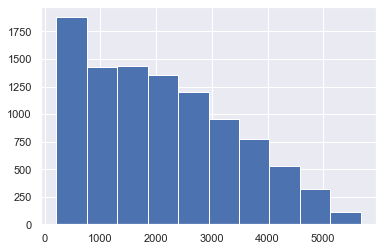

In [301]:
plt.hist(rmse)

In [306]:
idx = np.where(rmse < 300)

In [310]:
idx_min = rmse.argmin()

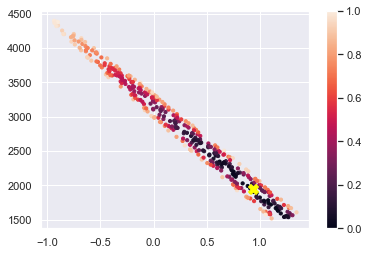

In [321]:
plt.scatter(k[idx], v0[idx], c=rmse[idx], s=10)
plt.scatter(k[idx_min], v0[idx_min], c='yellow', s=100, marker='X')
plt.colorbar()